In [1]:
import cupy
import cugraph
import cuml
import cudf
import numpy as np
from cuml.neighbors import NearestNeighbors
from cuml import TruncatedSVD, PCA, GaussianRandomProjection, SparseRandomProjection
from cuml import UMAP, TSNE
import time
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import silhouette_score
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # Decoder
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [3]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [4]:
def train(vae, fingerprints, epoch):
    dataloader = torch.utils.data.DataLoader(dataset=cupy.asnumpy(fingerprints), batch_size=256, shuffle=True)
    optimizer = optim.Adam(vae.parameters())
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        data = data.cuda()
        data = data.type(torch.cuda.FloatTensor)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(dataloader.dataset),
            100. * batch_idx / len(dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    return vae

In [5]:
def trainer(fingerprints, num_epochs=5):
    vae = VAE(x_dim=fingerprints.shape[1], h_dim1= 256, h_dim2=128, z_dim=2)
    vae.cuda() 
    for epoch in range(num_epochs):
        vae = train(vae, fingerprints, epoch)
    return vae

In [6]:
def get_embedding(vae, fingerprints):
    fingerprints = torch.from_numpy(cupy.asnumpy(fingerprints)).cuda().type(torch.cuda.FloatTensor)
    mu, var = vae.encoder(fingerprints)
    return mu

In [7]:
def compute_clusters_kmeans(embedding):
    embedding = cupy.asarray(embedding.detach())
    model = cuml.KMeans()
    model.fit(embedding)
    return model.predict(embedding)

In [8]:
def plot_molecules(embedding, clusters):
    ax = plt.axes()
    embedding = cupy.asnumpy(embedding.detach())
    clusters = cupy.asnumpy(clusters)
    ax.scatter(embedding[:,0], embedding[:,1], c=clusters, cmap="plasma")
    plt.show()

In [10]:
def batched_silhouette(embedding, clusters):
    rand_idxs = np.array(list(range(0,len(embedding))))
    np.random.shuffle(rand_idxs)
    embedding = cupy.asnumpy(embedding.detach())[rand_idxs]
    clusters = cupy.asnumpy(clusters)[rand_idxs]
    scores = []
    batch_size = 5000
    for i in range(0, len(embedding), batch_size):
        score = silhouette_score(embedding[i:i+batch_size], clusters[i:i+batch_size])
        print(score)
        scores.append(score)
    return np.mean(scores)

In [11]:
def run_pipeline_kmeans(fingerprints_file):
    fp = cupy.load(fingerprints_file, allow_pickle=True)
    start = time.time()
    vae = trainer(fp)
    embedding = get_embedding(vae, fp)
    print("Training VAE took " + str(time.time()-start) + " seconds")
    start = time.time()
    clusters = compute_clusters_kmeans(embedding)
    print("Computing KMeans clusters took " + str(time.time()-start) + " seconds")
    start = time.time()
    plot_molecules(embedding, clusters)
    print("Plotting took " + str(time.time()-start) + " seconds")
    silhouette = batched_silhouette(embedding, clusters)
    print("Average silhouette score: " + str(silhouette))

/home/rmohan/anaconda3/envs/rapids-0.17/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/500000 (0%)]	Loss: 355.589813
Train Epoch: 0 [256/500000 (0%)]	Loss: 348.050903
Train Epoch: 0 [512/500000 (0%)]	Loss: 340.160767
Train Epoch: 0 [768/500000 (0%)]	Loss: 331.862091
Train Epoch: 0 [1024/500000 (0%)]	Loss: 321.697815
Train Epoch: 0 [1280/500000 (0%)]	Loss: 310.497681
Train Epoch: 0 [1536/500000 (0%)]	Loss: 297.114044
Train Epoch: 0 [1792/500000 (0%)]	Loss: 278.934631
Train Epoch: 0 [2048/500000 (0%)]	Loss: 260.124969
Train Epoch: 0 [2304/500000 (0%)]	Loss: 236.301010
Train Epoch: 0 [2560/500000 (1%)]	Loss: 216.844849
Train Epoch: 0 [2816/500000 (1%)]	Loss: 196.658035
Train Epoch: 0 [3072/500000 (1%)]	Loss: 184.536041
Train Epoch: 0 [3328/500000 (1%)]	Loss: 178.740662
Train Epoch: 0 [3584/500000 (1%)]	Loss: 180.169662
Train Epoch: 0 [3840/500000 (1%)]	Loss: 202.751205
Train Epoch: 0 [4096/500000 (1%)]	Loss: 171.392487
Train Epoch: 0 [4352/500000 (1%)]	Loss: 177.827835
Train Epoch: 0 [4608/500000 (1%)]	Loss: 168.985107
Train Epoch: 0 [4864/500000 (1%)]	Los

Train Epoch: 0 [51456/500000 (10%)]	Loss: 133.009689
Train Epoch: 0 [51712/500000 (10%)]	Loss: 135.832504
Train Epoch: 0 [51968/500000 (10%)]	Loss: 132.591110
Train Epoch: 0 [52224/500000 (10%)]	Loss: 130.985046
Train Epoch: 0 [52480/500000 (10%)]	Loss: 132.681717
Train Epoch: 0 [52736/500000 (11%)]	Loss: 133.855072
Train Epoch: 0 [52992/500000 (11%)]	Loss: 131.900040
Train Epoch: 0 [53248/500000 (11%)]	Loss: 133.745850
Train Epoch: 0 [53504/500000 (11%)]	Loss: 136.852188
Train Epoch: 0 [53760/500000 (11%)]	Loss: 131.591980
Train Epoch: 0 [54016/500000 (11%)]	Loss: 134.998993
Train Epoch: 0 [54272/500000 (11%)]	Loss: 135.144424
Train Epoch: 0 [54528/500000 (11%)]	Loss: 132.469238
Train Epoch: 0 [54784/500000 (11%)]	Loss: 133.002151
Train Epoch: 0 [55040/500000 (11%)]	Loss: 131.245483
Train Epoch: 0 [55296/500000 (11%)]	Loss: 134.966690
Train Epoch: 0 [55552/500000 (11%)]	Loss: 131.033203
Train Epoch: 0 [55808/500000 (11%)]	Loss: 135.371826
Train Epoch: 0 [56064/500000 (11%)]	Loss: 130.

Train Epoch: 0 [103680/500000 (21%)]	Loss: 127.581810
Train Epoch: 0 [103936/500000 (21%)]	Loss: 136.108093
Train Epoch: 0 [104192/500000 (21%)]	Loss: 131.753036
Train Epoch: 0 [104448/500000 (21%)]	Loss: 130.651413
Train Epoch: 0 [104704/500000 (21%)]	Loss: 132.501389
Train Epoch: 0 [104960/500000 (21%)]	Loss: 131.800858
Train Epoch: 0 [105216/500000 (21%)]	Loss: 129.880463
Train Epoch: 0 [105472/500000 (21%)]	Loss: 129.912674
Train Epoch: 0 [105728/500000 (21%)]	Loss: 128.895721
Train Epoch: 0 [105984/500000 (21%)]	Loss: 129.283340
Train Epoch: 0 [106240/500000 (21%)]	Loss: 131.658295
Train Epoch: 0 [106496/500000 (21%)]	Loss: 131.883163
Train Epoch: 0 [106752/500000 (21%)]	Loss: 130.443634
Train Epoch: 0 [107008/500000 (21%)]	Loss: 129.969254
Train Epoch: 0 [107264/500000 (21%)]	Loss: 129.986221
Train Epoch: 0 [107520/500000 (21%)]	Loss: 130.989548
Train Epoch: 0 [107776/500000 (22%)]	Loss: 132.210144
Train Epoch: 0 [108032/500000 (22%)]	Loss: 130.801300
Train Epoch: 0 [108288/50000

Train Epoch: 0 [142848/500000 (29%)]	Loss: 125.187225
Train Epoch: 0 [143104/500000 (29%)]	Loss: 127.441139
Train Epoch: 0 [143360/500000 (29%)]	Loss: 128.117645
Train Epoch: 0 [143616/500000 (29%)]	Loss: 129.329102
Train Epoch: 0 [143872/500000 (29%)]	Loss: 128.787445
Train Epoch: 0 [144128/500000 (29%)]	Loss: 128.467911
Train Epoch: 0 [144384/500000 (29%)]	Loss: 128.006531
Train Epoch: 0 [144640/500000 (29%)]	Loss: 132.062210
Train Epoch: 0 [144896/500000 (29%)]	Loss: 128.301147
Train Epoch: 0 [145152/500000 (29%)]	Loss: 128.306015
Train Epoch: 0 [145408/500000 (29%)]	Loss: 126.805710
Train Epoch: 0 [145664/500000 (29%)]	Loss: 126.632439
Train Epoch: 0 [145920/500000 (29%)]	Loss: 128.690628
Train Epoch: 0 [146176/500000 (29%)]	Loss: 130.213837
Train Epoch: 0 [146432/500000 (29%)]	Loss: 125.977982
Train Epoch: 0 [146688/500000 (29%)]	Loss: 128.845200
Train Epoch: 0 [146944/500000 (29%)]	Loss: 130.480118
Train Epoch: 0 [147200/500000 (29%)]	Loss: 127.719810
Train Epoch: 0 [147456/50000

Train Epoch: 0 [182016/500000 (36%)]	Loss: 129.432388
Train Epoch: 0 [182272/500000 (36%)]	Loss: 125.873428
Train Epoch: 0 [182528/500000 (36%)]	Loss: 129.507217
Train Epoch: 0 [182784/500000 (37%)]	Loss: 128.808563
Train Epoch: 0 [183040/500000 (37%)]	Loss: 126.789055
Train Epoch: 0 [183296/500000 (37%)]	Loss: 129.711273
Train Epoch: 0 [183552/500000 (37%)]	Loss: 131.242065
Train Epoch: 0 [183808/500000 (37%)]	Loss: 126.417793
Train Epoch: 0 [184064/500000 (37%)]	Loss: 129.830811
Train Epoch: 0 [184320/500000 (37%)]	Loss: 129.181854
Train Epoch: 0 [184576/500000 (37%)]	Loss: 126.887596
Train Epoch: 0 [184832/500000 (37%)]	Loss: 127.306633
Train Epoch: 0 [185088/500000 (37%)]	Loss: 129.770462
Train Epoch: 0 [185344/500000 (37%)]	Loss: 126.924820
Train Epoch: 0 [185600/500000 (37%)]	Loss: 128.268188
Train Epoch: 0 [185856/500000 (37%)]	Loss: 128.210449
Train Epoch: 0 [186112/500000 (37%)]	Loss: 129.863342
Train Epoch: 0 [186368/500000 (37%)]	Loss: 127.210007
Train Epoch: 0 [186624/50000

Train Epoch: 0 [221184/500000 (44%)]	Loss: 126.310066
Train Epoch: 0 [221440/500000 (44%)]	Loss: 128.321808
Train Epoch: 0 [221696/500000 (44%)]	Loss: 127.361252
Train Epoch: 0 [221952/500000 (44%)]	Loss: 129.855621
Train Epoch: 0 [222208/500000 (44%)]	Loss: 128.291367
Train Epoch: 0 [222464/500000 (44%)]	Loss: 126.331993
Train Epoch: 0 [222720/500000 (45%)]	Loss: 126.691429
Train Epoch: 0 [222976/500000 (45%)]	Loss: 128.079895
Train Epoch: 0 [223232/500000 (45%)]	Loss: 126.733650
Train Epoch: 0 [223488/500000 (45%)]	Loss: 130.655701
Train Epoch: 0 [223744/500000 (45%)]	Loss: 128.282669
Train Epoch: 0 [224000/500000 (45%)]	Loss: 124.767433
Train Epoch: 0 [224256/500000 (45%)]	Loss: 127.911392
Train Epoch: 0 [224512/500000 (45%)]	Loss: 131.135391
Train Epoch: 0 [224768/500000 (45%)]	Loss: 127.369484
Train Epoch: 0 [225024/500000 (45%)]	Loss: 124.738403
Train Epoch: 0 [225280/500000 (45%)]	Loss: 125.599564
Train Epoch: 0 [225536/500000 (45%)]	Loss: 127.113190
Train Epoch: 0 [225792/50000

Train Epoch: 0 [260352/500000 (52%)]	Loss: 129.447662
Train Epoch: 0 [260608/500000 (52%)]	Loss: 127.011948
Train Epoch: 0 [260864/500000 (52%)]	Loss: 127.548035
Train Epoch: 0 [261120/500000 (52%)]	Loss: 122.530098
Train Epoch: 0 [261376/500000 (52%)]	Loss: 126.836273
Train Epoch: 0 [261632/500000 (52%)]	Loss: 128.276657
Train Epoch: 0 [261888/500000 (52%)]	Loss: 125.570877
Train Epoch: 0 [262144/500000 (52%)]	Loss: 126.468010
Train Epoch: 0 [262400/500000 (52%)]	Loss: 125.447968
Train Epoch: 0 [262656/500000 (53%)]	Loss: 128.296143
Train Epoch: 0 [262912/500000 (53%)]	Loss: 127.511253
Train Epoch: 0 [263168/500000 (53%)]	Loss: 128.957474
Train Epoch: 0 [263424/500000 (53%)]	Loss: 124.405533
Train Epoch: 0 [263680/500000 (53%)]	Loss: 126.432243
Train Epoch: 0 [263936/500000 (53%)]	Loss: 123.981850
Train Epoch: 0 [264192/500000 (53%)]	Loss: 127.760384
Train Epoch: 0 [264448/500000 (53%)]	Loss: 128.572067
Train Epoch: 0 [264704/500000 (53%)]	Loss: 128.936722
Train Epoch: 0 [264960/50000

Train Epoch: 0 [299520/500000 (60%)]	Loss: 128.060638
Train Epoch: 0 [299776/500000 (60%)]	Loss: 127.500565
Train Epoch: 0 [300032/500000 (60%)]	Loss: 125.190918
Train Epoch: 0 [300288/500000 (60%)]	Loss: 126.156410
Train Epoch: 0 [300544/500000 (60%)]	Loss: 127.746521
Train Epoch: 0 [300800/500000 (60%)]	Loss: 126.282242
Train Epoch: 0 [301056/500000 (60%)]	Loss: 128.726074
Train Epoch: 0 [301312/500000 (60%)]	Loss: 128.262039
Train Epoch: 0 [301568/500000 (60%)]	Loss: 126.066902
Train Epoch: 0 [301824/500000 (60%)]	Loss: 127.659195
Train Epoch: 0 [302080/500000 (60%)]	Loss: 126.150635
Train Epoch: 0 [302336/500000 (60%)]	Loss: 126.178703
Train Epoch: 0 [302592/500000 (60%)]	Loss: 125.691589
Train Epoch: 0 [302848/500000 (61%)]	Loss: 127.079208
Train Epoch: 0 [303104/500000 (61%)]	Loss: 123.338882
Train Epoch: 0 [303360/500000 (61%)]	Loss: 126.815750
Train Epoch: 0 [303616/500000 (61%)]	Loss: 126.175964
Train Epoch: 0 [303872/500000 (61%)]	Loss: 124.483330
Train Epoch: 0 [304128/50000

Train Epoch: 0 [338688/500000 (68%)]	Loss: 128.329956
Train Epoch: 0 [338944/500000 (68%)]	Loss: 126.211014
Train Epoch: 0 [339200/500000 (68%)]	Loss: 130.632156
Train Epoch: 0 [339456/500000 (68%)]	Loss: 127.179474
Train Epoch: 0 [339712/500000 (68%)]	Loss: 125.764793
Train Epoch: 0 [339968/500000 (68%)]	Loss: 125.440216
Train Epoch: 0 [340224/500000 (68%)]	Loss: 128.000381
Train Epoch: 0 [340480/500000 (68%)]	Loss: 130.693054
Train Epoch: 0 [340736/500000 (68%)]	Loss: 125.631371
Train Epoch: 0 [340992/500000 (68%)]	Loss: 124.505219
Train Epoch: 0 [341248/500000 (68%)]	Loss: 125.566505
Train Epoch: 0 [341504/500000 (68%)]	Loss: 123.493591
Train Epoch: 0 [341760/500000 (68%)]	Loss: 122.728493
Train Epoch: 0 [342016/500000 (68%)]	Loss: 125.834511
Train Epoch: 0 [342272/500000 (68%)]	Loss: 126.993477
Train Epoch: 0 [342528/500000 (68%)]	Loss: 126.491112
Train Epoch: 0 [342784/500000 (69%)]	Loss: 124.592407
Train Epoch: 0 [343040/500000 (69%)]	Loss: 125.060326
Train Epoch: 0 [343296/50000

Train Epoch: 0 [377856/500000 (76%)]	Loss: 123.902641
Train Epoch: 0 [378112/500000 (76%)]	Loss: 124.167046
Train Epoch: 0 [378368/500000 (76%)]	Loss: 125.445732
Train Epoch: 0 [378624/500000 (76%)]	Loss: 126.618515
Train Epoch: 0 [378880/500000 (76%)]	Loss: 128.763336
Train Epoch: 0 [379136/500000 (76%)]	Loss: 125.168144
Train Epoch: 0 [379392/500000 (76%)]	Loss: 128.079224
Train Epoch: 0 [379648/500000 (76%)]	Loss: 126.195389
Train Epoch: 0 [379904/500000 (76%)]	Loss: 127.683746
Train Epoch: 0 [380160/500000 (76%)]	Loss: 128.801147
Train Epoch: 0 [380416/500000 (76%)]	Loss: 126.962700
Train Epoch: 0 [380672/500000 (76%)]	Loss: 129.198868
Train Epoch: 0 [380928/500000 (76%)]	Loss: 125.334320
Train Epoch: 0 [381184/500000 (76%)]	Loss: 125.478104
Train Epoch: 0 [381440/500000 (76%)]	Loss: 127.874809
Train Epoch: 0 [381696/500000 (76%)]	Loss: 126.300148
Train Epoch: 0 [381952/500000 (76%)]	Loss: 128.790192
Train Epoch: 0 [382208/500000 (76%)]	Loss: 127.662125
Train Epoch: 0 [382464/50000

Train Epoch: 0 [417024/500000 (83%)]	Loss: 124.331879
Train Epoch: 0 [417280/500000 (83%)]	Loss: 125.762955
Train Epoch: 0 [417536/500000 (83%)]	Loss: 124.896393
Train Epoch: 0 [417792/500000 (84%)]	Loss: 123.545341
Train Epoch: 0 [418048/500000 (84%)]	Loss: 127.780754
Train Epoch: 0 [418304/500000 (84%)]	Loss: 124.254364
Train Epoch: 0 [418560/500000 (84%)]	Loss: 124.892036
Train Epoch: 0 [418816/500000 (84%)]	Loss: 125.587540
Train Epoch: 0 [419072/500000 (84%)]	Loss: 123.181870
Train Epoch: 0 [419328/500000 (84%)]	Loss: 127.534447
Train Epoch: 0 [419584/500000 (84%)]	Loss: 125.712418
Train Epoch: 0 [419840/500000 (84%)]	Loss: 125.155235
Train Epoch: 0 [420096/500000 (84%)]	Loss: 126.592720
Train Epoch: 0 [420352/500000 (84%)]	Loss: 127.050842
Train Epoch: 0 [420608/500000 (84%)]	Loss: 128.423676
Train Epoch: 0 [420864/500000 (84%)]	Loss: 127.118805
Train Epoch: 0 [421120/500000 (84%)]	Loss: 125.114532
Train Epoch: 0 [421376/500000 (84%)]	Loss: 124.944054
Train Epoch: 0 [421632/50000

Train Epoch: 0 [456192/500000 (91%)]	Loss: 123.245544
Train Epoch: 0 [456448/500000 (91%)]	Loss: 124.846466
Train Epoch: 0 [456704/500000 (91%)]	Loss: 123.333717
Train Epoch: 0 [456960/500000 (91%)]	Loss: 125.514931
Train Epoch: 0 [457216/500000 (91%)]	Loss: 127.736153
Train Epoch: 0 [457472/500000 (91%)]	Loss: 126.487831
Train Epoch: 0 [457728/500000 (92%)]	Loss: 125.993103
Train Epoch: 0 [457984/500000 (92%)]	Loss: 123.437378
Train Epoch: 0 [458240/500000 (92%)]	Loss: 127.154892
Train Epoch: 0 [458496/500000 (92%)]	Loss: 125.379883
Train Epoch: 0 [458752/500000 (92%)]	Loss: 126.525894
Train Epoch: 0 [459008/500000 (92%)]	Loss: 123.183380
Train Epoch: 0 [459264/500000 (92%)]	Loss: 123.845970
Train Epoch: 0 [459520/500000 (92%)]	Loss: 126.386467
Train Epoch: 0 [459776/500000 (92%)]	Loss: 125.003807
Train Epoch: 0 [460032/500000 (92%)]	Loss: 125.123192
Train Epoch: 0 [460288/500000 (92%)]	Loss: 125.907608
Train Epoch: 0 [460544/500000 (92%)]	Loss: 123.287132
Train Epoch: 0 [460800/50000

Train Epoch: 0 [495360/500000 (99%)]	Loss: 127.561340
Train Epoch: 0 [495616/500000 (99%)]	Loss: 123.484772
Train Epoch: 0 [495872/500000 (99%)]	Loss: 124.623550
Train Epoch: 0 [496128/500000 (99%)]	Loss: 130.296722
Train Epoch: 0 [496384/500000 (99%)]	Loss: 125.896736
Train Epoch: 0 [496640/500000 (99%)]	Loss: 122.673660
Train Epoch: 0 [496896/500000 (99%)]	Loss: 125.315414
Train Epoch: 0 [497152/500000 (99%)]	Loss: 126.829346
Train Epoch: 0 [497408/500000 (99%)]	Loss: 125.522583
Train Epoch: 0 [497664/500000 (99%)]	Loss: 124.067001
Train Epoch: 0 [497920/500000 (100%)]	Loss: 123.746544
Train Epoch: 0 [498176/500000 (100%)]	Loss: 125.350327
Train Epoch: 0 [498432/500000 (100%)]	Loss: 123.838783
Train Epoch: 0 [498688/500000 (100%)]	Loss: 125.789345
Train Epoch: 0 [498944/500000 (100%)]	Loss: 125.565834
Train Epoch: 0 [499200/500000 (100%)]	Loss: 123.712181
Train Epoch: 0 [499456/500000 (100%)]	Loss: 124.191551
Train Epoch: 0 [499712/500000 (100%)]	Loss: 124.716370
Train Epoch: 0 [6249

Train Epoch: 1 [39168/500000 (8%)]	Loss: 126.175072
Train Epoch: 1 [39424/500000 (8%)]	Loss: 124.155823
Train Epoch: 1 [39680/500000 (8%)]	Loss: 125.756836
Train Epoch: 1 [39936/500000 (8%)]	Loss: 124.632919
Train Epoch: 1 [40192/500000 (8%)]	Loss: 130.065445
Train Epoch: 1 [40448/500000 (8%)]	Loss: 126.224403
Train Epoch: 1 [40704/500000 (8%)]	Loss: 123.796951
Train Epoch: 1 [40960/500000 (8%)]	Loss: 122.769913
Train Epoch: 1 [41216/500000 (8%)]	Loss: 126.817368
Train Epoch: 1 [41472/500000 (8%)]	Loss: 124.529541
Train Epoch: 1 [41728/500000 (8%)]	Loss: 124.852272
Train Epoch: 1 [41984/500000 (8%)]	Loss: 124.939499
Train Epoch: 1 [42240/500000 (8%)]	Loss: 123.866295
Train Epoch: 1 [42496/500000 (8%)]	Loss: 125.872231
Train Epoch: 1 [42752/500000 (9%)]	Loss: 123.311424
Train Epoch: 1 [43008/500000 (9%)]	Loss: 123.386848
Train Epoch: 1 [43264/500000 (9%)]	Loss: 126.411858
Train Epoch: 1 [43520/500000 (9%)]	Loss: 124.785400
Train Epoch: 1 [43776/500000 (9%)]	Loss: 126.059418
Train Epoch:

Train Epoch: 1 [91392/500000 (18%)]	Loss: 124.725983
Train Epoch: 1 [91648/500000 (18%)]	Loss: 128.920242
Train Epoch: 1 [91904/500000 (18%)]	Loss: 125.296761
Train Epoch: 1 [92160/500000 (18%)]	Loss: 124.434975
Train Epoch: 1 [92416/500000 (18%)]	Loss: 126.776871
Train Epoch: 1 [92672/500000 (19%)]	Loss: 127.183098
Train Epoch: 1 [92928/500000 (19%)]	Loss: 125.631577
Train Epoch: 1 [93184/500000 (19%)]	Loss: 124.097778
Train Epoch: 1 [93440/500000 (19%)]	Loss: 127.839851
Train Epoch: 1 [93696/500000 (19%)]	Loss: 126.542755
Train Epoch: 1 [93952/500000 (19%)]	Loss: 125.579788
Train Epoch: 1 [94208/500000 (19%)]	Loss: 125.602570
Train Epoch: 1 [94464/500000 (19%)]	Loss: 124.808289
Train Epoch: 1 [94720/500000 (19%)]	Loss: 125.772858
Train Epoch: 1 [94976/500000 (19%)]	Loss: 123.260078
Train Epoch: 1 [95232/500000 (19%)]	Loss: 124.069016
Train Epoch: 1 [95488/500000 (19%)]	Loss: 122.588745
Train Epoch: 1 [95744/500000 (19%)]	Loss: 123.432495
Train Epoch: 1 [96000/500000 (19%)]	Loss: 125.

Train Epoch: 1 [130560/500000 (26%)]	Loss: 122.146713
Train Epoch: 1 [130816/500000 (26%)]	Loss: 124.033203
Train Epoch: 1 [131072/500000 (26%)]	Loss: 121.059120
Train Epoch: 1 [131328/500000 (26%)]	Loss: 128.005554
Train Epoch: 1 [131584/500000 (26%)]	Loss: 126.043777
Train Epoch: 1 [131840/500000 (26%)]	Loss: 126.142532
Train Epoch: 1 [132096/500000 (26%)]	Loss: 124.902946
Train Epoch: 1 [132352/500000 (26%)]	Loss: 126.829102
Train Epoch: 1 [132608/500000 (27%)]	Loss: 123.231117
Train Epoch: 1 [132864/500000 (27%)]	Loss: 127.639229
Train Epoch: 1 [133120/500000 (27%)]	Loss: 126.776283
Train Epoch: 1 [133376/500000 (27%)]	Loss: 124.356552
Train Epoch: 1 [133632/500000 (27%)]	Loss: 124.285522
Train Epoch: 1 [133888/500000 (27%)]	Loss: 120.488205
Train Epoch: 1 [134144/500000 (27%)]	Loss: 124.821945
Train Epoch: 1 [134400/500000 (27%)]	Loss: 125.547012
Train Epoch: 1 [134656/500000 (27%)]	Loss: 126.511925
Train Epoch: 1 [134912/500000 (27%)]	Loss: 123.061478
Train Epoch: 1 [135168/50000

Train Epoch: 1 [169728/500000 (34%)]	Loss: 123.951118
Train Epoch: 1 [169984/500000 (34%)]	Loss: 125.994125
Train Epoch: 1 [170240/500000 (34%)]	Loss: 123.509125
Train Epoch: 1 [170496/500000 (34%)]	Loss: 126.458527
Train Epoch: 1 [170752/500000 (34%)]	Loss: 128.548019
Train Epoch: 1 [171008/500000 (34%)]	Loss: 125.821808
Train Epoch: 1 [171264/500000 (34%)]	Loss: 125.802322
Train Epoch: 1 [171520/500000 (34%)]	Loss: 126.888939
Train Epoch: 1 [171776/500000 (34%)]	Loss: 126.268005
Train Epoch: 1 [172032/500000 (34%)]	Loss: 126.474487
Train Epoch: 1 [172288/500000 (34%)]	Loss: 125.280556
Train Epoch: 1 [172544/500000 (34%)]	Loss: 124.909599
Train Epoch: 1 [172800/500000 (35%)]	Loss: 124.760231
Train Epoch: 1 [173056/500000 (35%)]	Loss: 128.101089
Train Epoch: 1 [173312/500000 (35%)]	Loss: 126.520996
Train Epoch: 1 [173568/500000 (35%)]	Loss: 125.874985
Train Epoch: 1 [173824/500000 (35%)]	Loss: 125.857231
Train Epoch: 1 [174080/500000 (35%)]	Loss: 125.627487
Train Epoch: 1 [174336/50000

Train Epoch: 1 [208896/500000 (42%)]	Loss: 124.705879
Train Epoch: 1 [209152/500000 (42%)]	Loss: 125.530334
Train Epoch: 1 [209408/500000 (42%)]	Loss: 126.592056
Train Epoch: 1 [209664/500000 (42%)]	Loss: 125.078865
Train Epoch: 1 [209920/500000 (42%)]	Loss: 125.020470
Train Epoch: 1 [210176/500000 (42%)]	Loss: 125.032150
Train Epoch: 1 [210432/500000 (42%)]	Loss: 124.000282
Train Epoch: 1 [210688/500000 (42%)]	Loss: 124.658165
Train Epoch: 1 [210944/500000 (42%)]	Loss: 123.155220
Train Epoch: 1 [211200/500000 (42%)]	Loss: 126.746315
Train Epoch: 1 [211456/500000 (42%)]	Loss: 124.673859
Train Epoch: 1 [211712/500000 (42%)]	Loss: 124.891472
Train Epoch: 1 [211968/500000 (42%)]	Loss: 125.667137
Train Epoch: 1 [212224/500000 (42%)]	Loss: 125.664703
Train Epoch: 1 [212480/500000 (42%)]	Loss: 122.439354
Train Epoch: 1 [212736/500000 (43%)]	Loss: 124.922386
Train Epoch: 1 [212992/500000 (43%)]	Loss: 122.786430
Train Epoch: 1 [213248/500000 (43%)]	Loss: 123.476357
Train Epoch: 1 [213504/50000

Train Epoch: 1 [251392/500000 (50%)]	Loss: 126.648911
Train Epoch: 1 [251648/500000 (50%)]	Loss: 123.070564
Train Epoch: 1 [251904/500000 (50%)]	Loss: 126.177315
Train Epoch: 1 [252160/500000 (50%)]	Loss: 123.242828
Train Epoch: 1 [252416/500000 (50%)]	Loss: 125.908691
Train Epoch: 1 [252672/500000 (51%)]	Loss: 122.903397
Train Epoch: 1 [252928/500000 (51%)]	Loss: 124.722160
Train Epoch: 1 [253184/500000 (51%)]	Loss: 127.973236
Train Epoch: 1 [253440/500000 (51%)]	Loss: 122.428108
Train Epoch: 1 [253696/500000 (51%)]	Loss: 125.774803
Train Epoch: 1 [253952/500000 (51%)]	Loss: 127.659615
Train Epoch: 1 [254208/500000 (51%)]	Loss: 120.247780
Train Epoch: 1 [254464/500000 (51%)]	Loss: 126.177849
Train Epoch: 1 [254720/500000 (51%)]	Loss: 123.555077
Train Epoch: 1 [254976/500000 (51%)]	Loss: 128.135559
Train Epoch: 1 [255232/500000 (51%)]	Loss: 124.117203
Train Epoch: 1 [255488/500000 (51%)]	Loss: 124.926208
Train Epoch: 1 [255744/500000 (51%)]	Loss: 122.122871
Train Epoch: 1 [256000/50000

Train Epoch: 1 [295936/500000 (59%)]	Loss: 122.332245
Train Epoch: 1 [296192/500000 (59%)]	Loss: 125.200882
Train Epoch: 1 [296448/500000 (59%)]	Loss: 126.007202
Train Epoch: 1 [296704/500000 (59%)]	Loss: 122.101364
Train Epoch: 1 [296960/500000 (59%)]	Loss: 124.767082
Train Epoch: 1 [297216/500000 (59%)]	Loss: 125.091965
Train Epoch: 1 [297472/500000 (59%)]	Loss: 126.410713
Train Epoch: 1 [297728/500000 (60%)]	Loss: 127.659485
Train Epoch: 1 [297984/500000 (60%)]	Loss: 124.652390
Train Epoch: 1 [298240/500000 (60%)]	Loss: 125.288147
Train Epoch: 1 [298496/500000 (60%)]	Loss: 125.273972
Train Epoch: 1 [298752/500000 (60%)]	Loss: 124.944138
Train Epoch: 1 [299008/500000 (60%)]	Loss: 124.741615
Train Epoch: 1 [299264/500000 (60%)]	Loss: 124.966888
Train Epoch: 1 [299520/500000 (60%)]	Loss: 123.522926
Train Epoch: 1 [299776/500000 (60%)]	Loss: 126.439751
Train Epoch: 1 [300032/500000 (60%)]	Loss: 127.600548
Train Epoch: 1 [300288/500000 (60%)]	Loss: 123.676201
Train Epoch: 1 [300544/50000

Train Epoch: 1 [339968/500000 (68%)]	Loss: 121.533150
Train Epoch: 1 [340224/500000 (68%)]	Loss: 123.616920
Train Epoch: 1 [340480/500000 (68%)]	Loss: 126.674232
Train Epoch: 1 [340736/500000 (68%)]	Loss: 125.503593
Train Epoch: 1 [340992/500000 (68%)]	Loss: 121.381348
Train Epoch: 1 [341248/500000 (68%)]	Loss: 124.511787
Train Epoch: 1 [341504/500000 (68%)]	Loss: 122.844070
Train Epoch: 1 [341760/500000 (68%)]	Loss: 124.170738
Train Epoch: 1 [342016/500000 (68%)]	Loss: 127.801842
Train Epoch: 1 [342272/500000 (68%)]	Loss: 124.597824
Train Epoch: 1 [342528/500000 (68%)]	Loss: 125.661293
Train Epoch: 1 [342784/500000 (69%)]	Loss: 124.162224
Train Epoch: 1 [343040/500000 (69%)]	Loss: 128.045029
Train Epoch: 1 [343296/500000 (69%)]	Loss: 124.234108
Train Epoch: 1 [343552/500000 (69%)]	Loss: 124.788795
Train Epoch: 1 [343808/500000 (69%)]	Loss: 125.957909
Train Epoch: 1 [344064/500000 (69%)]	Loss: 123.717453
Train Epoch: 1 [344320/500000 (69%)]	Loss: 122.287979
Train Epoch: 1 [344576/50000

Train Epoch: 1 [383232/500000 (77%)]	Loss: 124.525368
Train Epoch: 1 [383488/500000 (77%)]	Loss: 124.193146
Train Epoch: 1 [383744/500000 (77%)]	Loss: 125.034485
Train Epoch: 1 [384000/500000 (77%)]	Loss: 124.910591
Train Epoch: 1 [384256/500000 (77%)]	Loss: 121.025826
Train Epoch: 1 [384512/500000 (77%)]	Loss: 123.904274
Train Epoch: 1 [384768/500000 (77%)]	Loss: 122.230408
Train Epoch: 1 [385024/500000 (77%)]	Loss: 122.288887
Train Epoch: 1 [385280/500000 (77%)]	Loss: 124.889854
Train Epoch: 1 [385536/500000 (77%)]	Loss: 123.623520
Train Epoch: 1 [385792/500000 (77%)]	Loss: 122.499573
Train Epoch: 1 [386048/500000 (77%)]	Loss: 124.258377
Train Epoch: 1 [386304/500000 (77%)]	Loss: 123.848770
Train Epoch: 1 [386560/500000 (77%)]	Loss: 122.797165
Train Epoch: 1 [386816/500000 (77%)]	Loss: 122.239609
Train Epoch: 1 [387072/500000 (77%)]	Loss: 125.069611
Train Epoch: 1 [387328/500000 (77%)]	Loss: 124.942543
Train Epoch: 1 [387584/500000 (77%)]	Loss: 122.345184
Train Epoch: 1 [387840/50000

Train Epoch: 1 [427008/500000 (85%)]	Loss: 122.525635
Train Epoch: 1 [427264/500000 (85%)]	Loss: 125.667450
Train Epoch: 1 [427520/500000 (85%)]	Loss: 125.788467
Train Epoch: 1 [427776/500000 (86%)]	Loss: 122.046577
Train Epoch: 1 [428032/500000 (86%)]	Loss: 125.513962
Train Epoch: 1 [428288/500000 (86%)]	Loss: 124.576691
Train Epoch: 1 [428544/500000 (86%)]	Loss: 121.340431
Train Epoch: 1 [428800/500000 (86%)]	Loss: 122.525505
Train Epoch: 1 [429056/500000 (86%)]	Loss: 126.319153
Train Epoch: 1 [429312/500000 (86%)]	Loss: 123.244247
Train Epoch: 1 [429568/500000 (86%)]	Loss: 124.260246
Train Epoch: 1 [429824/500000 (86%)]	Loss: 124.426994
Train Epoch: 1 [430080/500000 (86%)]	Loss: 123.329910
Train Epoch: 1 [430336/500000 (86%)]	Loss: 122.401482
Train Epoch: 1 [430592/500000 (86%)]	Loss: 124.274445
Train Epoch: 1 [430848/500000 (86%)]	Loss: 121.625946
Train Epoch: 1 [431104/500000 (86%)]	Loss: 125.882538
Train Epoch: 1 [431360/500000 (86%)]	Loss: 125.172806
Train Epoch: 1 [431616/50000

Train Epoch: 1 [471552/500000 (94%)]	Loss: 122.577774
Train Epoch: 1 [471808/500000 (94%)]	Loss: 124.762703
Train Epoch: 1 [472064/500000 (94%)]	Loss: 122.643883
Train Epoch: 1 [472320/500000 (94%)]	Loss: 124.317345
Train Epoch: 1 [472576/500000 (94%)]	Loss: 123.250458
Train Epoch: 1 [472832/500000 (95%)]	Loss: 124.504402
Train Epoch: 1 [473088/500000 (95%)]	Loss: 124.384193
Train Epoch: 1 [473344/500000 (95%)]	Loss: 126.736885
Train Epoch: 1 [473600/500000 (95%)]	Loss: 125.226631
Train Epoch: 1 [473856/500000 (95%)]	Loss: 124.510780
Train Epoch: 1 [474112/500000 (95%)]	Loss: 121.720467
Train Epoch: 1 [474368/500000 (95%)]	Loss: 125.089493
Train Epoch: 1 [474624/500000 (95%)]	Loss: 125.520935
Train Epoch: 1 [474880/500000 (95%)]	Loss: 123.792236
Train Epoch: 1 [475136/500000 (95%)]	Loss: 123.493401
Train Epoch: 1 [475392/500000 (95%)]	Loss: 123.374039
Train Epoch: 1 [475648/500000 (95%)]	Loss: 125.494690
Train Epoch: 1 [475904/500000 (95%)]	Loss: 125.229454
Train Epoch: 1 [476160/50000

Train Epoch: 2 [16384/500000 (3%)]	Loss: 124.471481
Train Epoch: 2 [16640/500000 (3%)]	Loss: 124.765411
Train Epoch: 2 [16896/500000 (3%)]	Loss: 126.042084
Train Epoch: 2 [17152/500000 (3%)]	Loss: 124.492905
Train Epoch: 2 [17408/500000 (3%)]	Loss: 125.814560
Train Epoch: 2 [17664/500000 (4%)]	Loss: 125.192146
Train Epoch: 2 [17920/500000 (4%)]	Loss: 124.044205
Train Epoch: 2 [18176/500000 (4%)]	Loss: 124.687248
Train Epoch: 2 [18432/500000 (4%)]	Loss: 124.012459
Train Epoch: 2 [18688/500000 (4%)]	Loss: 124.365288
Train Epoch: 2 [18944/500000 (4%)]	Loss: 126.047318
Train Epoch: 2 [19200/500000 (4%)]	Loss: 125.525978
Train Epoch: 2 [19456/500000 (4%)]	Loss: 123.127350
Train Epoch: 2 [19712/500000 (4%)]	Loss: 121.801041
Train Epoch: 2 [19968/500000 (4%)]	Loss: 124.320328
Train Epoch: 2 [20224/500000 (4%)]	Loss: 122.192200
Train Epoch: 2 [20480/500000 (4%)]	Loss: 121.385139
Train Epoch: 2 [20736/500000 (4%)]	Loss: 119.899635
Train Epoch: 2 [20992/500000 (4%)]	Loss: 125.091141
Train Epoch:

Train Epoch: 2 [59904/500000 (12%)]	Loss: 122.792534
Train Epoch: 2 [60160/500000 (12%)]	Loss: 126.283081
Train Epoch: 2 [60416/500000 (12%)]	Loss: 126.329842
Train Epoch: 2 [60672/500000 (12%)]	Loss: 125.695312
Train Epoch: 2 [60928/500000 (12%)]	Loss: 124.345276
Train Epoch: 2 [61184/500000 (12%)]	Loss: 126.315346
Train Epoch: 2 [61440/500000 (12%)]	Loss: 123.232559
Train Epoch: 2 [61696/500000 (12%)]	Loss: 126.327011
Train Epoch: 2 [61952/500000 (12%)]	Loss: 124.808426
Train Epoch: 2 [62208/500000 (12%)]	Loss: 123.824547
Train Epoch: 2 [62464/500000 (12%)]	Loss: 124.805595
Train Epoch: 2 [62720/500000 (13%)]	Loss: 122.247292
Train Epoch: 2 [62976/500000 (13%)]	Loss: 121.929283
Train Epoch: 2 [63232/500000 (13%)]	Loss: 123.098358
Train Epoch: 2 [63488/500000 (13%)]	Loss: 122.094284
Train Epoch: 2 [63744/500000 (13%)]	Loss: 123.219833
Train Epoch: 2 [64000/500000 (13%)]	Loss: 127.835449
Train Epoch: 2 [64256/500000 (13%)]	Loss: 125.054565
Train Epoch: 2 [64512/500000 (13%)]	Loss: 123.

Train Epoch: 2 [103936/500000 (21%)]	Loss: 122.195229
Train Epoch: 2 [104192/500000 (21%)]	Loss: 122.803665
Train Epoch: 2 [104448/500000 (21%)]	Loss: 120.363052
Train Epoch: 2 [104704/500000 (21%)]	Loss: 124.864334
Train Epoch: 2 [104960/500000 (21%)]	Loss: 123.914810
Train Epoch: 2 [105216/500000 (21%)]	Loss: 122.985924
Train Epoch: 2 [105472/500000 (21%)]	Loss: 124.665367
Train Epoch: 2 [105728/500000 (21%)]	Loss: 122.553680
Train Epoch: 2 [105984/500000 (21%)]	Loss: 124.329956
Train Epoch: 2 [106240/500000 (21%)]	Loss: 124.015610
Train Epoch: 2 [106496/500000 (21%)]	Loss: 123.848602
Train Epoch: 2 [106752/500000 (21%)]	Loss: 126.542786
Train Epoch: 2 [107008/500000 (21%)]	Loss: 124.310188
Train Epoch: 2 [107264/500000 (21%)]	Loss: 125.019249
Train Epoch: 2 [107520/500000 (21%)]	Loss: 121.464005
Train Epoch: 2 [107776/500000 (22%)]	Loss: 122.163429
Train Epoch: 2 [108032/500000 (22%)]	Loss: 126.666122
Train Epoch: 2 [108288/500000 (22%)]	Loss: 123.871216
Train Epoch: 2 [108544/50000

Train Epoch: 2 [148480/500000 (30%)]	Loss: 122.901993
Train Epoch: 2 [148736/500000 (30%)]	Loss: 124.767799
Train Epoch: 2 [148992/500000 (30%)]	Loss: 121.052208
Train Epoch: 2 [149248/500000 (30%)]	Loss: 123.441452
Train Epoch: 2 [149504/500000 (30%)]	Loss: 125.389870
Train Epoch: 2 [149760/500000 (30%)]	Loss: 121.347984
Train Epoch: 2 [150016/500000 (30%)]	Loss: 124.262825
Train Epoch: 2 [150272/500000 (30%)]	Loss: 122.233665
Train Epoch: 2 [150528/500000 (30%)]	Loss: 120.438965
Train Epoch: 2 [150784/500000 (30%)]	Loss: 122.481010
Train Epoch: 2 [151040/500000 (30%)]	Loss: 122.863426
Train Epoch: 2 [151296/500000 (30%)]	Loss: 122.906960
Train Epoch: 2 [151552/500000 (30%)]	Loss: 124.955124
Train Epoch: 2 [151808/500000 (30%)]	Loss: 119.291397
Train Epoch: 2 [152064/500000 (30%)]	Loss: 124.453560
Train Epoch: 2 [152320/500000 (30%)]	Loss: 121.912941
Train Epoch: 2 [152576/500000 (31%)]	Loss: 125.267914
Train Epoch: 2 [152832/500000 (31%)]	Loss: 124.907616
Train Epoch: 2 [153088/50000

Train Epoch: 2 [193024/500000 (39%)]	Loss: 122.696716
Train Epoch: 2 [193280/500000 (39%)]	Loss: 120.900673
Train Epoch: 2 [193536/500000 (39%)]	Loss: 120.903580
Train Epoch: 2 [193792/500000 (39%)]	Loss: 121.908623
Train Epoch: 2 [194048/500000 (39%)]	Loss: 122.379433
Train Epoch: 2 [194304/500000 (39%)]	Loss: 124.525246
Train Epoch: 2 [194560/500000 (39%)]	Loss: 124.509445
Train Epoch: 2 [194816/500000 (39%)]	Loss: 119.770744
Train Epoch: 2 [195072/500000 (39%)]	Loss: 124.395828
Train Epoch: 2 [195328/500000 (39%)]	Loss: 123.716393
Train Epoch: 2 [195584/500000 (39%)]	Loss: 125.074684
Train Epoch: 2 [195840/500000 (39%)]	Loss: 126.124390
Train Epoch: 2 [196096/500000 (39%)]	Loss: 122.315300
Train Epoch: 2 [196352/500000 (39%)]	Loss: 123.390274
Train Epoch: 2 [196608/500000 (39%)]	Loss: 124.215050
Train Epoch: 2 [196864/500000 (39%)]	Loss: 122.687134
Train Epoch: 2 [197120/500000 (39%)]	Loss: 119.098328
Train Epoch: 2 [197376/500000 (39%)]	Loss: 126.343002
Train Epoch: 2 [197632/50000

Train Epoch: 2 [237568/500000 (47%)]	Loss: 123.397110
Train Epoch: 2 [237824/500000 (48%)]	Loss: 123.491539
Train Epoch: 2 [238080/500000 (48%)]	Loss: 124.267273
Train Epoch: 2 [238336/500000 (48%)]	Loss: 122.814308
Train Epoch: 2 [238592/500000 (48%)]	Loss: 127.595673
Train Epoch: 2 [238848/500000 (48%)]	Loss: 118.494751
Train Epoch: 2 [239104/500000 (48%)]	Loss: 121.786911
Train Epoch: 2 [239360/500000 (48%)]	Loss: 123.571198
Train Epoch: 2 [239616/500000 (48%)]	Loss: 122.900154
Train Epoch: 2 [239872/500000 (48%)]	Loss: 122.677689
Train Epoch: 2 [240128/500000 (48%)]	Loss: 121.368248
Train Epoch: 2 [240384/500000 (48%)]	Loss: 124.170914
Train Epoch: 2 [240640/500000 (48%)]	Loss: 123.443916
Train Epoch: 2 [240896/500000 (48%)]	Loss: 123.266068
Train Epoch: 2 [241152/500000 (48%)]	Loss: 126.377953
Train Epoch: 2 [241408/500000 (48%)]	Loss: 122.043846
Train Epoch: 2 [241664/500000 (48%)]	Loss: 125.415916
Train Epoch: 2 [241920/500000 (48%)]	Loss: 121.979797
Train Epoch: 2 [242176/50000

Train Epoch: 2 [282112/500000 (56%)]	Loss: 124.858124
Train Epoch: 2 [282368/500000 (56%)]	Loss: 125.091293
Train Epoch: 2 [282624/500000 (56%)]	Loss: 123.155579
Train Epoch: 2 [282880/500000 (57%)]	Loss: 121.950302
Train Epoch: 2 [283136/500000 (57%)]	Loss: 123.545021
Train Epoch: 2 [283392/500000 (57%)]	Loss: 121.934151
Train Epoch: 2 [283648/500000 (57%)]	Loss: 124.210457
Train Epoch: 2 [283904/500000 (57%)]	Loss: 125.199455
Train Epoch: 2 [284160/500000 (57%)]	Loss: 122.340218
Train Epoch: 2 [284416/500000 (57%)]	Loss: 123.273460
Train Epoch: 2 [284672/500000 (57%)]	Loss: 122.440033
Train Epoch: 2 [284928/500000 (57%)]	Loss: 119.924965
Train Epoch: 2 [285184/500000 (57%)]	Loss: 122.791962
Train Epoch: 2 [285440/500000 (57%)]	Loss: 122.898964
Train Epoch: 2 [285696/500000 (57%)]	Loss: 122.887970
Train Epoch: 2 [285952/500000 (57%)]	Loss: 123.041672
Train Epoch: 2 [286208/500000 (57%)]	Loss: 126.674034
Train Epoch: 2 [286464/500000 (57%)]	Loss: 124.672821
Train Epoch: 2 [286720/50000

Train Epoch: 2 [324608/500000 (65%)]	Loss: 121.957184
Train Epoch: 2 [324864/500000 (65%)]	Loss: 121.073318
Train Epoch: 2 [325120/500000 (65%)]	Loss: 122.670151
Train Epoch: 2 [325376/500000 (65%)]	Loss: 124.470993
Train Epoch: 2 [325632/500000 (65%)]	Loss: 121.786026
Train Epoch: 2 [325888/500000 (65%)]	Loss: 122.278214
Train Epoch: 2 [326144/500000 (65%)]	Loss: 125.708054
Train Epoch: 2 [326400/500000 (65%)]	Loss: 122.481102
Train Epoch: 2 [326656/500000 (65%)]	Loss: 122.429451
Train Epoch: 2 [326912/500000 (65%)]	Loss: 122.288467
Train Epoch: 2 [327168/500000 (65%)]	Loss: 124.294807
Train Epoch: 2 [327424/500000 (65%)]	Loss: 123.467850
Train Epoch: 2 [327680/500000 (66%)]	Loss: 120.333176
Train Epoch: 2 [327936/500000 (66%)]	Loss: 121.123886
Train Epoch: 2 [328192/500000 (66%)]	Loss: 120.684341
Train Epoch: 2 [328448/500000 (66%)]	Loss: 125.736183
Train Epoch: 2 [328704/500000 (66%)]	Loss: 119.923180
Train Epoch: 2 [328960/500000 (66%)]	Loss: 122.148369
Train Epoch: 2 [329216/50000

Train Epoch: 2 [367616/500000 (73%)]	Loss: 122.408859
Train Epoch: 2 [367872/500000 (74%)]	Loss: 122.113258
Train Epoch: 2 [368128/500000 (74%)]	Loss: 120.233780
Train Epoch: 2 [368384/500000 (74%)]	Loss: 123.656334
Train Epoch: 2 [368640/500000 (74%)]	Loss: 119.742264
Train Epoch: 2 [368896/500000 (74%)]	Loss: 118.068886
Train Epoch: 2 [369152/500000 (74%)]	Loss: 124.749489
Train Epoch: 2 [369408/500000 (74%)]	Loss: 127.235718
Train Epoch: 2 [369664/500000 (74%)]	Loss: 124.978004
Train Epoch: 2 [369920/500000 (74%)]	Loss: 123.645584
Train Epoch: 2 [370176/500000 (74%)]	Loss: 122.922844
Train Epoch: 2 [370432/500000 (74%)]	Loss: 125.501945
Train Epoch: 2 [370688/500000 (74%)]	Loss: 121.135643
Train Epoch: 2 [370944/500000 (74%)]	Loss: 123.364296
Train Epoch: 2 [371200/500000 (74%)]	Loss: 122.087143
Train Epoch: 2 [371456/500000 (74%)]	Loss: 125.078163
Train Epoch: 2 [371712/500000 (74%)]	Loss: 122.566414
Train Epoch: 2 [371968/500000 (74%)]	Loss: 122.493637
Train Epoch: 2 [372224/50000

Train Epoch: 2 [409856/500000 (82%)]	Loss: 124.223785
Train Epoch: 2 [410112/500000 (82%)]	Loss: 124.664490
Train Epoch: 2 [410368/500000 (82%)]	Loss: 124.419052
Train Epoch: 2 [410624/500000 (82%)]	Loss: 127.320938
Train Epoch: 2 [410880/500000 (82%)]	Loss: 122.408829
Train Epoch: 2 [411136/500000 (82%)]	Loss: 123.304543
Train Epoch: 2 [411392/500000 (82%)]	Loss: 121.482033
Train Epoch: 2 [411648/500000 (82%)]	Loss: 122.873291
Train Epoch: 2 [411904/500000 (82%)]	Loss: 124.143448
Train Epoch: 2 [412160/500000 (82%)]	Loss: 122.696693
Train Epoch: 2 [412416/500000 (82%)]	Loss: 121.876564
Train Epoch: 2 [412672/500000 (82%)]	Loss: 123.237007
Train Epoch: 2 [412928/500000 (83%)]	Loss: 123.636307
Train Epoch: 2 [413184/500000 (83%)]	Loss: 124.675980
Train Epoch: 2 [413440/500000 (83%)]	Loss: 123.767937
Train Epoch: 2 [413696/500000 (83%)]	Loss: 120.312340
Train Epoch: 2 [413952/500000 (83%)]	Loss: 123.386848
Train Epoch: 2 [414208/500000 (83%)]	Loss: 123.370422
Train Epoch: 2 [414464/50000

Train Epoch: 2 [449024/500000 (90%)]	Loss: 122.510147
Train Epoch: 2 [449280/500000 (90%)]	Loss: 121.940605
Train Epoch: 2 [449536/500000 (90%)]	Loss: 123.340034
Train Epoch: 2 [449792/500000 (90%)]	Loss: 123.639084
Train Epoch: 2 [450048/500000 (90%)]	Loss: 122.709991
Train Epoch: 2 [450304/500000 (90%)]	Loss: 121.445976
Train Epoch: 2 [450560/500000 (90%)]	Loss: 120.099571
Train Epoch: 2 [450816/500000 (90%)]	Loss: 121.956184
Train Epoch: 2 [451072/500000 (90%)]	Loss: 122.369652
Train Epoch: 2 [451328/500000 (90%)]	Loss: 125.110023
Train Epoch: 2 [451584/500000 (90%)]	Loss: 121.779709
Train Epoch: 2 [451840/500000 (90%)]	Loss: 122.821480
Train Epoch: 2 [452096/500000 (90%)]	Loss: 123.461700
Train Epoch: 2 [452352/500000 (90%)]	Loss: 123.766167
Train Epoch: 2 [452608/500000 (90%)]	Loss: 125.343338
Train Epoch: 2 [452864/500000 (91%)]	Loss: 125.284164
Train Epoch: 2 [453120/500000 (91%)]	Loss: 119.053490
Train Epoch: 2 [453376/500000 (91%)]	Loss: 128.146362
Train Epoch: 2 [453632/50000

Train Epoch: 2 [488192/500000 (98%)]	Loss: 124.326729
Train Epoch: 2 [488448/500000 (98%)]	Loss: 122.836800
Train Epoch: 2 [488704/500000 (98%)]	Loss: 122.575340
Train Epoch: 2 [488960/500000 (98%)]	Loss: 122.634514
Train Epoch: 2 [489216/500000 (98%)]	Loss: 124.172447
Train Epoch: 2 [489472/500000 (98%)]	Loss: 123.466858
Train Epoch: 2 [489728/500000 (98%)]	Loss: 122.377296
Train Epoch: 2 [489984/500000 (98%)]	Loss: 121.192108
Train Epoch: 2 [490240/500000 (98%)]	Loss: 120.339737
Train Epoch: 2 [490496/500000 (98%)]	Loss: 121.136925
Train Epoch: 2 [490752/500000 (98%)]	Loss: 123.439232
Train Epoch: 2 [491008/500000 (98%)]	Loss: 121.543152
Train Epoch: 2 [491264/500000 (98%)]	Loss: 122.987953
Train Epoch: 2 [491520/500000 (98%)]	Loss: 123.544991
Train Epoch: 2 [491776/500000 (98%)]	Loss: 124.351501
Train Epoch: 2 [492032/500000 (98%)]	Loss: 121.633102
Train Epoch: 2 [492288/500000 (98%)]	Loss: 122.918648
Train Epoch: 2 [492544/500000 (98%)]	Loss: 122.278641
Train Epoch: 2 [492800/50000

Train Epoch: 3 [39168/500000 (8%)]	Loss: 119.458763
Train Epoch: 3 [39424/500000 (8%)]	Loss: 127.454712
Train Epoch: 3 [39680/500000 (8%)]	Loss: 123.824028
Train Epoch: 3 [39936/500000 (8%)]	Loss: 122.546356
Train Epoch: 3 [40192/500000 (8%)]	Loss: 123.149895
Train Epoch: 3 [40448/500000 (8%)]	Loss: 121.766335
Train Epoch: 3 [40704/500000 (8%)]	Loss: 120.911758
Train Epoch: 3 [40960/500000 (8%)]	Loss: 122.718460
Train Epoch: 3 [41216/500000 (8%)]	Loss: 123.299202
Train Epoch: 3 [41472/500000 (8%)]	Loss: 125.206291
Train Epoch: 3 [41728/500000 (8%)]	Loss: 120.657867
Train Epoch: 3 [41984/500000 (8%)]	Loss: 121.543671
Train Epoch: 3 [42240/500000 (8%)]	Loss: 120.899025
Train Epoch: 3 [42496/500000 (8%)]	Loss: 120.747078
Train Epoch: 3 [42752/500000 (9%)]	Loss: 123.731178
Train Epoch: 3 [43008/500000 (9%)]	Loss: 121.890106
Train Epoch: 3 [43264/500000 (9%)]	Loss: 124.680916
Train Epoch: 3 [43520/500000 (9%)]	Loss: 121.282051
Train Epoch: 3 [43776/500000 (9%)]	Loss: 122.368744
Train Epoch:

Train Epoch: 3 [91392/500000 (18%)]	Loss: 122.193306
Train Epoch: 3 [91648/500000 (18%)]	Loss: 126.423264
Train Epoch: 3 [91904/500000 (18%)]	Loss: 122.268402
Train Epoch: 3 [92160/500000 (18%)]	Loss: 124.635376
Train Epoch: 3 [92416/500000 (18%)]	Loss: 124.090218
Train Epoch: 3 [92672/500000 (19%)]	Loss: 123.432381
Train Epoch: 3 [92928/500000 (19%)]	Loss: 122.837051
Train Epoch: 3 [93184/500000 (19%)]	Loss: 122.494110
Train Epoch: 3 [93440/500000 (19%)]	Loss: 121.409332
Train Epoch: 3 [93696/500000 (19%)]	Loss: 124.580368
Train Epoch: 3 [93952/500000 (19%)]	Loss: 122.990356
Train Epoch: 3 [94208/500000 (19%)]	Loss: 122.795441
Train Epoch: 3 [94464/500000 (19%)]	Loss: 121.873962
Train Epoch: 3 [94720/500000 (19%)]	Loss: 123.010254
Train Epoch: 3 [94976/500000 (19%)]	Loss: 125.209145
Train Epoch: 3 [95232/500000 (19%)]	Loss: 125.531616
Train Epoch: 3 [95488/500000 (19%)]	Loss: 125.332001
Train Epoch: 3 [95744/500000 (19%)]	Loss: 123.518433
Train Epoch: 3 [96000/500000 (19%)]	Loss: 122.

Train Epoch: 3 [130560/500000 (26%)]	Loss: 122.661034
Train Epoch: 3 [130816/500000 (26%)]	Loss: 121.071144
Train Epoch: 3 [131072/500000 (26%)]	Loss: 121.133820
Train Epoch: 3 [131328/500000 (26%)]	Loss: 124.240112
Train Epoch: 3 [131584/500000 (26%)]	Loss: 119.170639
Train Epoch: 3 [131840/500000 (26%)]	Loss: 124.531662
Train Epoch: 3 [132096/500000 (26%)]	Loss: 124.031822
Train Epoch: 3 [132352/500000 (26%)]	Loss: 120.602371
Train Epoch: 3 [132608/500000 (27%)]	Loss: 121.199570
Train Epoch: 3 [132864/500000 (27%)]	Loss: 121.307991
Train Epoch: 3 [133120/500000 (27%)]	Loss: 123.009476
Train Epoch: 3 [133376/500000 (27%)]	Loss: 124.058098
Train Epoch: 3 [133632/500000 (27%)]	Loss: 123.863525
Train Epoch: 3 [133888/500000 (27%)]	Loss: 123.099396
Train Epoch: 3 [134144/500000 (27%)]	Loss: 123.453407
Train Epoch: 3 [134400/500000 (27%)]	Loss: 123.477623
Train Epoch: 3 [134656/500000 (27%)]	Loss: 123.030655
Train Epoch: 3 [134912/500000 (27%)]	Loss: 123.302689
Train Epoch: 3 [135168/50000

Train Epoch: 3 [169728/500000 (34%)]	Loss: 121.840111
Train Epoch: 3 [169984/500000 (34%)]	Loss: 120.363007
Train Epoch: 3 [170240/500000 (34%)]	Loss: 120.847603
Train Epoch: 3 [170496/500000 (34%)]	Loss: 121.957130
Train Epoch: 3 [170752/500000 (34%)]	Loss: 121.842133
Train Epoch: 3 [171008/500000 (34%)]	Loss: 120.318001
Train Epoch: 3 [171264/500000 (34%)]	Loss: 121.760536
Train Epoch: 3 [171520/500000 (34%)]	Loss: 121.733574
Train Epoch: 3 [171776/500000 (34%)]	Loss: 122.476280
Train Epoch: 3 [172032/500000 (34%)]	Loss: 123.161713
Train Epoch: 3 [172288/500000 (34%)]	Loss: 121.798019
Train Epoch: 3 [172544/500000 (34%)]	Loss: 122.900047
Train Epoch: 3 [172800/500000 (35%)]	Loss: 124.546844
Train Epoch: 3 [173056/500000 (35%)]	Loss: 121.497276
Train Epoch: 3 [173312/500000 (35%)]	Loss: 122.224182
Train Epoch: 3 [173568/500000 (35%)]	Loss: 124.319305
Train Epoch: 3 [173824/500000 (35%)]	Loss: 119.109795
Train Epoch: 3 [174080/500000 (35%)]	Loss: 121.847893
Train Epoch: 3 [174336/50000

Train Epoch: 3 [208896/500000 (42%)]	Loss: 121.116547
Train Epoch: 3 [209152/500000 (42%)]	Loss: 121.492210
Train Epoch: 3 [209408/500000 (42%)]	Loss: 122.490990
Train Epoch: 3 [209664/500000 (42%)]	Loss: 125.622948
Train Epoch: 3 [209920/500000 (42%)]	Loss: 123.369186
Train Epoch: 3 [210176/500000 (42%)]	Loss: 125.210983
Train Epoch: 3 [210432/500000 (42%)]	Loss: 123.806030
Train Epoch: 3 [210688/500000 (42%)]	Loss: 123.651154
Train Epoch: 3 [210944/500000 (42%)]	Loss: 120.906204
Train Epoch: 3 [211200/500000 (42%)]	Loss: 126.101067
Train Epoch: 3 [211456/500000 (42%)]	Loss: 121.377686
Train Epoch: 3 [211712/500000 (42%)]	Loss: 121.821411
Train Epoch: 3 [211968/500000 (42%)]	Loss: 127.016571
Train Epoch: 3 [212224/500000 (42%)]	Loss: 121.869537
Train Epoch: 3 [212480/500000 (42%)]	Loss: 121.303612
Train Epoch: 3 [212736/500000 (43%)]	Loss: 123.867393
Train Epoch: 3 [212992/500000 (43%)]	Loss: 124.426880
Train Epoch: 3 [213248/500000 (43%)]	Loss: 121.682137
Train Epoch: 3 [213504/50000

Train Epoch: 3 [248064/500000 (50%)]	Loss: 121.950233
Train Epoch: 3 [248320/500000 (50%)]	Loss: 125.410789
Train Epoch: 3 [248576/500000 (50%)]	Loss: 122.737785
Train Epoch: 3 [248832/500000 (50%)]	Loss: 121.591087
Train Epoch: 3 [249088/500000 (50%)]	Loss: 122.453094
Train Epoch: 3 [249344/500000 (50%)]	Loss: 121.861160
Train Epoch: 3 [249600/500000 (50%)]	Loss: 122.711708
Train Epoch: 3 [249856/500000 (50%)]	Loss: 123.527946
Train Epoch: 3 [250112/500000 (50%)]	Loss: 124.558662
Train Epoch: 3 [250368/500000 (50%)]	Loss: 125.056305
Train Epoch: 3 [250624/500000 (50%)]	Loss: 120.940796
Train Epoch: 3 [250880/500000 (50%)]	Loss: 122.328659
Train Epoch: 3 [251136/500000 (50%)]	Loss: 123.303574
Train Epoch: 3 [251392/500000 (50%)]	Loss: 123.677032
Train Epoch: 3 [251648/500000 (50%)]	Loss: 122.605927
Train Epoch: 3 [251904/500000 (50%)]	Loss: 120.340485
Train Epoch: 3 [252160/500000 (50%)]	Loss: 122.275246
Train Epoch: 3 [252416/500000 (50%)]	Loss: 121.823799
Train Epoch: 3 [252672/50000

Train Epoch: 3 [287232/500000 (57%)]	Loss: 124.351189
Train Epoch: 3 [287488/500000 (57%)]	Loss: 124.998344
Train Epoch: 3 [287744/500000 (58%)]	Loss: 121.528069
Train Epoch: 3 [288000/500000 (58%)]	Loss: 122.527069
Train Epoch: 3 [288256/500000 (58%)]	Loss: 120.763824
Train Epoch: 3 [288512/500000 (58%)]	Loss: 124.275558
Train Epoch: 3 [288768/500000 (58%)]	Loss: 120.976669
Train Epoch: 3 [289024/500000 (58%)]	Loss: 120.955238
Train Epoch: 3 [289280/500000 (58%)]	Loss: 119.928642
Train Epoch: 3 [289536/500000 (58%)]	Loss: 122.715652
Train Epoch: 3 [289792/500000 (58%)]	Loss: 120.313332
Train Epoch: 3 [290048/500000 (58%)]	Loss: 126.345657
Train Epoch: 3 [290304/500000 (58%)]	Loss: 120.221344
Train Epoch: 3 [290560/500000 (58%)]	Loss: 120.003494
Train Epoch: 3 [290816/500000 (58%)]	Loss: 122.398628
Train Epoch: 3 [291072/500000 (58%)]	Loss: 119.324295
Train Epoch: 3 [291328/500000 (58%)]	Loss: 120.610909
Train Epoch: 3 [291584/500000 (58%)]	Loss: 121.882477
Train Epoch: 3 [291840/50000

Train Epoch: 3 [326400/500000 (65%)]	Loss: 124.418541
Train Epoch: 3 [326656/500000 (65%)]	Loss: 123.659515
Train Epoch: 3 [326912/500000 (65%)]	Loss: 124.030022
Train Epoch: 3 [327168/500000 (65%)]	Loss: 120.741089
Train Epoch: 3 [327424/500000 (65%)]	Loss: 123.907227
Train Epoch: 3 [327680/500000 (66%)]	Loss: 122.811676
Train Epoch: 3 [327936/500000 (66%)]	Loss: 124.690628
Train Epoch: 3 [328192/500000 (66%)]	Loss: 123.120758
Train Epoch: 3 [328448/500000 (66%)]	Loss: 120.494400
Train Epoch: 3 [328704/500000 (66%)]	Loss: 122.990242
Train Epoch: 3 [328960/500000 (66%)]	Loss: 121.535446
Train Epoch: 3 [329216/500000 (66%)]	Loss: 121.801788
Train Epoch: 3 [329472/500000 (66%)]	Loss: 119.607071
Train Epoch: 3 [329728/500000 (66%)]	Loss: 120.168564
Train Epoch: 3 [329984/500000 (66%)]	Loss: 123.728142
Train Epoch: 3 [330240/500000 (66%)]	Loss: 120.121880
Train Epoch: 3 [330496/500000 (66%)]	Loss: 123.752739
Train Epoch: 3 [330752/500000 (66%)]	Loss: 121.577507
Train Epoch: 3 [331008/50000

Train Epoch: 3 [365568/500000 (73%)]	Loss: 123.821861
Train Epoch: 3 [365824/500000 (73%)]	Loss: 121.735840
Train Epoch: 3 [366080/500000 (73%)]	Loss: 124.010361
Train Epoch: 3 [366336/500000 (73%)]	Loss: 119.750847
Train Epoch: 3 [366592/500000 (73%)]	Loss: 121.377625
Train Epoch: 3 [366848/500000 (73%)]	Loss: 122.583389
Train Epoch: 3 [367104/500000 (73%)]	Loss: 123.606827
Train Epoch: 3 [367360/500000 (73%)]	Loss: 122.028114
Train Epoch: 3 [367616/500000 (73%)]	Loss: 121.135498
Train Epoch: 3 [367872/500000 (74%)]	Loss: 119.712334
Train Epoch: 3 [368128/500000 (74%)]	Loss: 123.189453
Train Epoch: 3 [368384/500000 (74%)]	Loss: 123.599045
Train Epoch: 3 [368640/500000 (74%)]	Loss: 122.791359
Train Epoch: 3 [368896/500000 (74%)]	Loss: 121.977104
Train Epoch: 3 [369152/500000 (74%)]	Loss: 119.734497
Train Epoch: 3 [369408/500000 (74%)]	Loss: 124.173813
Train Epoch: 3 [369664/500000 (74%)]	Loss: 121.309097
Train Epoch: 3 [369920/500000 (74%)]	Loss: 120.157936
Train Epoch: 3 [370176/50000

Train Epoch: 3 [404736/500000 (81%)]	Loss: 123.177460
Train Epoch: 3 [404992/500000 (81%)]	Loss: 122.337906
Train Epoch: 3 [405248/500000 (81%)]	Loss: 120.166344
Train Epoch: 3 [405504/500000 (81%)]	Loss: 124.255463
Train Epoch: 3 [405760/500000 (81%)]	Loss: 118.364609
Train Epoch: 3 [406016/500000 (81%)]	Loss: 123.084389
Train Epoch: 3 [406272/500000 (81%)]	Loss: 122.751564
Train Epoch: 3 [406528/500000 (81%)]	Loss: 122.546333
Train Epoch: 3 [406784/500000 (81%)]	Loss: 125.443672
Train Epoch: 3 [407040/500000 (81%)]	Loss: 121.131180
Train Epoch: 3 [407296/500000 (81%)]	Loss: 123.928108
Train Epoch: 3 [407552/500000 (81%)]	Loss: 120.931427
Train Epoch: 3 [407808/500000 (82%)]	Loss: 124.376228
Train Epoch: 3 [408064/500000 (82%)]	Loss: 123.217499
Train Epoch: 3 [408320/500000 (82%)]	Loss: 122.628593
Train Epoch: 3 [408576/500000 (82%)]	Loss: 122.944763
Train Epoch: 3 [408832/500000 (82%)]	Loss: 124.163177
Train Epoch: 3 [409088/500000 (82%)]	Loss: 120.575325
Train Epoch: 3 [409344/50000

Train Epoch: 3 [443904/500000 (89%)]	Loss: 122.479721
Train Epoch: 3 [444160/500000 (89%)]	Loss: 121.393478
Train Epoch: 3 [444416/500000 (89%)]	Loss: 121.152275
Train Epoch: 3 [444672/500000 (89%)]	Loss: 123.251625
Train Epoch: 3 [444928/500000 (89%)]	Loss: 119.889931
Train Epoch: 3 [445184/500000 (89%)]	Loss: 123.929619
Train Epoch: 3 [445440/500000 (89%)]	Loss: 124.378159
Train Epoch: 3 [445696/500000 (89%)]	Loss: 124.152397
Train Epoch: 3 [445952/500000 (89%)]	Loss: 118.848595
Train Epoch: 3 [446208/500000 (89%)]	Loss: 123.657127
Train Epoch: 3 [446464/500000 (89%)]	Loss: 125.496223
Train Epoch: 3 [446720/500000 (89%)]	Loss: 120.270393
Train Epoch: 3 [446976/500000 (89%)]	Loss: 122.544136
Train Epoch: 3 [447232/500000 (89%)]	Loss: 123.463989
Train Epoch: 3 [447488/500000 (89%)]	Loss: 122.644859
Train Epoch: 3 [447744/500000 (90%)]	Loss: 124.139275
Train Epoch: 3 [448000/500000 (90%)]	Loss: 121.238884
Train Epoch: 3 [448256/500000 (90%)]	Loss: 124.737274
Train Epoch: 3 [448512/50000

Train Epoch: 3 [483072/500000 (97%)]	Loss: 122.245964
Train Epoch: 3 [483328/500000 (97%)]	Loss: 122.607391
Train Epoch: 3 [483584/500000 (97%)]	Loss: 124.304802
Train Epoch: 3 [483840/500000 (97%)]	Loss: 121.609512
Train Epoch: 3 [484096/500000 (97%)]	Loss: 122.151978
Train Epoch: 3 [484352/500000 (97%)]	Loss: 121.084030
Train Epoch: 3 [484608/500000 (97%)]	Loss: 127.315353
Train Epoch: 3 [484864/500000 (97%)]	Loss: 121.858170
Train Epoch: 3 [485120/500000 (97%)]	Loss: 120.987312
Train Epoch: 3 [485376/500000 (97%)]	Loss: 122.878220
Train Epoch: 3 [485632/500000 (97%)]	Loss: 122.901321
Train Epoch: 3 [485888/500000 (97%)]	Loss: 120.825363
Train Epoch: 3 [486144/500000 (97%)]	Loss: 124.023438
Train Epoch: 3 [486400/500000 (97%)]	Loss: 122.543686
Train Epoch: 3 [486656/500000 (97%)]	Loss: 123.063934
Train Epoch: 3 [486912/500000 (97%)]	Loss: 122.666100
Train Epoch: 3 [487168/500000 (97%)]	Loss: 121.825829
Train Epoch: 3 [487424/500000 (97%)]	Loss: 121.713394
Train Epoch: 3 [487680/50000

Train Epoch: 4 [26112/500000 (5%)]	Loss: 124.397545
Train Epoch: 4 [26368/500000 (5%)]	Loss: 124.012917
Train Epoch: 4 [26624/500000 (5%)]	Loss: 121.989433
Train Epoch: 4 [26880/500000 (5%)]	Loss: 122.341415
Train Epoch: 4 [27136/500000 (5%)]	Loss: 122.316620
Train Epoch: 4 [27392/500000 (5%)]	Loss: 121.366043
Train Epoch: 4 [27648/500000 (6%)]	Loss: 121.794151
Train Epoch: 4 [27904/500000 (6%)]	Loss: 122.100952
Train Epoch: 4 [28160/500000 (6%)]	Loss: 123.447411
Train Epoch: 4 [28416/500000 (6%)]	Loss: 120.298935
Train Epoch: 4 [28672/500000 (6%)]	Loss: 118.228470
Train Epoch: 4 [28928/500000 (6%)]	Loss: 123.697449
Train Epoch: 4 [29184/500000 (6%)]	Loss: 124.610970
Train Epoch: 4 [29440/500000 (6%)]	Loss: 118.860497
Train Epoch: 4 [29696/500000 (6%)]	Loss: 121.370453
Train Epoch: 4 [29952/500000 (6%)]	Loss: 123.132828
Train Epoch: 4 [30208/500000 (6%)]	Loss: 120.062378
Train Epoch: 4 [30464/500000 (6%)]	Loss: 118.614639
Train Epoch: 4 [30720/500000 (6%)]	Loss: 121.194328
Train Epoch:

Train Epoch: 4 [78336/500000 (16%)]	Loss: 123.229080
Train Epoch: 4 [78592/500000 (16%)]	Loss: 122.540970
Train Epoch: 4 [78848/500000 (16%)]	Loss: 127.049713
Train Epoch: 4 [79104/500000 (16%)]	Loss: 122.898720
Train Epoch: 4 [79360/500000 (16%)]	Loss: 121.209641
Train Epoch: 4 [79616/500000 (16%)]	Loss: 122.259392
Train Epoch: 4 [79872/500000 (16%)]	Loss: 120.305946
Train Epoch: 4 [80128/500000 (16%)]	Loss: 122.832130
Train Epoch: 4 [80384/500000 (16%)]	Loss: 122.155586
Train Epoch: 4 [80640/500000 (16%)]	Loss: 121.851868
Train Epoch: 4 [80896/500000 (16%)]	Loss: 121.065147
Train Epoch: 4 [81152/500000 (16%)]	Loss: 122.778809
Train Epoch: 4 [81408/500000 (16%)]	Loss: 119.694778
Train Epoch: 4 [81664/500000 (16%)]	Loss: 121.085793
Train Epoch: 4 [81920/500000 (16%)]	Loss: 120.731422
Train Epoch: 4 [82176/500000 (16%)]	Loss: 120.779297
Train Epoch: 4 [82432/500000 (16%)]	Loss: 124.529060
Train Epoch: 4 [82688/500000 (17%)]	Loss: 122.313522
Train Epoch: 4 [82944/500000 (17%)]	Loss: 124.

Train Epoch: 4 [130560/500000 (26%)]	Loss: 124.757721
Train Epoch: 4 [130816/500000 (26%)]	Loss: 121.959000
Train Epoch: 4 [131072/500000 (26%)]	Loss: 123.392258
Train Epoch: 4 [131328/500000 (26%)]	Loss: 124.869385
Train Epoch: 4 [131584/500000 (26%)]	Loss: 124.202415
Train Epoch: 4 [131840/500000 (26%)]	Loss: 120.609825
Train Epoch: 4 [132096/500000 (26%)]	Loss: 120.445778
Train Epoch: 4 [132352/500000 (26%)]	Loss: 122.754471
Train Epoch: 4 [132608/500000 (27%)]	Loss: 124.994698
Train Epoch: 4 [132864/500000 (27%)]	Loss: 123.232445
Train Epoch: 4 [133120/500000 (27%)]	Loss: 121.272308
Train Epoch: 4 [133376/500000 (27%)]	Loss: 120.463264
Train Epoch: 4 [133632/500000 (27%)]	Loss: 123.647217
Train Epoch: 4 [133888/500000 (27%)]	Loss: 123.685524
Train Epoch: 4 [134144/500000 (27%)]	Loss: 122.471634
Train Epoch: 4 [134400/500000 (27%)]	Loss: 120.614998
Train Epoch: 4 [134656/500000 (27%)]	Loss: 120.423119
Train Epoch: 4 [134912/500000 (27%)]	Loss: 121.455063
Train Epoch: 4 [135168/50000

Train Epoch: 4 [172032/500000 (34%)]	Loss: 123.521004
Train Epoch: 4 [172288/500000 (34%)]	Loss: 120.855759
Train Epoch: 4 [172544/500000 (34%)]	Loss: 123.329384
Train Epoch: 4 [172800/500000 (35%)]	Loss: 125.223946
Train Epoch: 4 [173056/500000 (35%)]	Loss: 123.794418
Train Epoch: 4 [173312/500000 (35%)]	Loss: 120.189674
Train Epoch: 4 [173568/500000 (35%)]	Loss: 121.290833
Train Epoch: 4 [173824/500000 (35%)]	Loss: 120.423683
Train Epoch: 4 [174080/500000 (35%)]	Loss: 123.187485
Train Epoch: 4 [174336/500000 (35%)]	Loss: 121.508118
Train Epoch: 4 [174592/500000 (35%)]	Loss: 121.559860
Train Epoch: 4 [174848/500000 (35%)]	Loss: 123.833511
Train Epoch: 4 [175104/500000 (35%)]	Loss: 124.358101
Train Epoch: 4 [175360/500000 (35%)]	Loss: 123.058304
Train Epoch: 4 [175616/500000 (35%)]	Loss: 120.115692
Train Epoch: 4 [175872/500000 (35%)]	Loss: 120.144783
Train Epoch: 4 [176128/500000 (35%)]	Loss: 123.559097
Train Epoch: 4 [176384/500000 (35%)]	Loss: 124.195702
Train Epoch: 4 [176640/50000

Train Epoch: 4 [216064/500000 (43%)]	Loss: 122.743591
Train Epoch: 4 [216320/500000 (43%)]	Loss: 121.434517
Train Epoch: 4 [216576/500000 (43%)]	Loss: 122.993729
Train Epoch: 4 [216832/500000 (43%)]	Loss: 123.755440
Train Epoch: 4 [217088/500000 (43%)]	Loss: 121.561813
Train Epoch: 4 [217344/500000 (43%)]	Loss: 121.785820
Train Epoch: 4 [217600/500000 (44%)]	Loss: 124.530663
Train Epoch: 4 [217856/500000 (44%)]	Loss: 124.936234
Train Epoch: 4 [218112/500000 (44%)]	Loss: 121.857559
Train Epoch: 4 [218368/500000 (44%)]	Loss: 121.830246
Train Epoch: 4 [218624/500000 (44%)]	Loss: 120.054428
Train Epoch: 4 [218880/500000 (44%)]	Loss: 119.673355
Train Epoch: 4 [219136/500000 (44%)]	Loss: 123.128044
Train Epoch: 4 [219392/500000 (44%)]	Loss: 122.764297
Train Epoch: 4 [219648/500000 (44%)]	Loss: 122.804413
Train Epoch: 4 [219904/500000 (44%)]	Loss: 123.669083
Train Epoch: 4 [220160/500000 (44%)]	Loss: 121.250381
Train Epoch: 4 [220416/500000 (44%)]	Loss: 122.275558
Train Epoch: 4 [220672/50000

Train Epoch: 4 [260096/500000 (52%)]	Loss: 121.895569
Train Epoch: 4 [260352/500000 (52%)]	Loss: 122.243813
Train Epoch: 4 [260608/500000 (52%)]	Loss: 121.790115
Train Epoch: 4 [260864/500000 (52%)]	Loss: 121.319077
Train Epoch: 4 [261120/500000 (52%)]	Loss: 123.550568
Train Epoch: 4 [261376/500000 (52%)]	Loss: 123.311172
Train Epoch: 4 [261632/500000 (52%)]	Loss: 122.249252
Train Epoch: 4 [261888/500000 (52%)]	Loss: 122.884834
Train Epoch: 4 [262144/500000 (52%)]	Loss: 124.494766
Train Epoch: 4 [262400/500000 (52%)]	Loss: 118.873535
Train Epoch: 4 [262656/500000 (53%)]	Loss: 123.560883
Train Epoch: 4 [262912/500000 (53%)]	Loss: 120.608200
Train Epoch: 4 [263168/500000 (53%)]	Loss: 122.511993
Train Epoch: 4 [263424/500000 (53%)]	Loss: 124.087608
Train Epoch: 4 [263680/500000 (53%)]	Loss: 119.195053
Train Epoch: 4 [263936/500000 (53%)]	Loss: 123.596062
Train Epoch: 4 [264192/500000 (53%)]	Loss: 121.514725
Train Epoch: 4 [264448/500000 (53%)]	Loss: 123.050316
Train Epoch: 4 [264704/50000

Train Epoch: 4 [301312/500000 (60%)]	Loss: 122.142868
Train Epoch: 4 [301568/500000 (60%)]	Loss: 120.974655
Train Epoch: 4 [301824/500000 (60%)]	Loss: 123.365723
Train Epoch: 4 [302080/500000 (60%)]	Loss: 123.565102
Train Epoch: 4 [302336/500000 (60%)]	Loss: 121.476860
Train Epoch: 4 [302592/500000 (60%)]	Loss: 119.703270
Train Epoch: 4 [302848/500000 (61%)]	Loss: 122.160126
Train Epoch: 4 [303104/500000 (61%)]	Loss: 124.834793
Train Epoch: 4 [303360/500000 (61%)]	Loss: 121.685562
Train Epoch: 4 [303616/500000 (61%)]	Loss: 121.807549
Train Epoch: 4 [303872/500000 (61%)]	Loss: 119.656380
Train Epoch: 4 [304128/500000 (61%)]	Loss: 121.159416
Train Epoch: 4 [304384/500000 (61%)]	Loss: 123.057945
Train Epoch: 4 [304640/500000 (61%)]	Loss: 123.471474
Train Epoch: 4 [304896/500000 (61%)]	Loss: 121.141830
Train Epoch: 4 [305152/500000 (61%)]	Loss: 120.308601
Train Epoch: 4 [305408/500000 (61%)]	Loss: 120.365288
Train Epoch: 4 [305664/500000 (61%)]	Loss: 121.814079
Train Epoch: 4 [305920/50000

Train Epoch: 4 [344064/500000 (69%)]	Loss: 122.989502
Train Epoch: 4 [344320/500000 (69%)]	Loss: 122.235779
Train Epoch: 4 [344576/500000 (69%)]	Loss: 121.883591
Train Epoch: 4 [344832/500000 (69%)]	Loss: 120.675270
Train Epoch: 4 [345088/500000 (69%)]	Loss: 124.102737
Train Epoch: 4 [345344/500000 (69%)]	Loss: 123.772362
Train Epoch: 4 [345600/500000 (69%)]	Loss: 119.632339
Train Epoch: 4 [345856/500000 (69%)]	Loss: 121.063698
Train Epoch: 4 [346112/500000 (69%)]	Loss: 121.650528
Train Epoch: 4 [346368/500000 (69%)]	Loss: 123.854683
Train Epoch: 4 [346624/500000 (69%)]	Loss: 121.215179
Train Epoch: 4 [346880/500000 (69%)]	Loss: 123.169746
Train Epoch: 4 [347136/500000 (69%)]	Loss: 122.781868
Train Epoch: 4 [347392/500000 (69%)]	Loss: 119.510864
Train Epoch: 4 [347648/500000 (69%)]	Loss: 122.820595
Train Epoch: 4 [347904/500000 (70%)]	Loss: 120.998871
Train Epoch: 4 [348160/500000 (70%)]	Loss: 121.289429
Train Epoch: 4 [348416/500000 (70%)]	Loss: 122.285614
Train Epoch: 4 [348672/50000

Train Epoch: 4 [387584/500000 (77%)]	Loss: 122.810730
Train Epoch: 4 [387840/500000 (78%)]	Loss: 121.266525
Train Epoch: 4 [388096/500000 (78%)]	Loss: 121.924133
Train Epoch: 4 [388352/500000 (78%)]	Loss: 124.102783
Train Epoch: 4 [388608/500000 (78%)]	Loss: 123.791542
Train Epoch: 4 [388864/500000 (78%)]	Loss: 120.671265
Train Epoch: 4 [389120/500000 (78%)]	Loss: 120.254227
Train Epoch: 4 [389376/500000 (78%)]	Loss: 122.494919
Train Epoch: 4 [389632/500000 (78%)]	Loss: 117.628944
Train Epoch: 4 [389888/500000 (78%)]	Loss: 121.339081
Train Epoch: 4 [390144/500000 (78%)]	Loss: 123.350220
Train Epoch: 4 [390400/500000 (78%)]	Loss: 120.241562
Train Epoch: 4 [390656/500000 (78%)]	Loss: 120.697845
Train Epoch: 4 [390912/500000 (78%)]	Loss: 119.805656
Train Epoch: 4 [391168/500000 (78%)]	Loss: 121.060326
Train Epoch: 4 [391424/500000 (78%)]	Loss: 123.523117
Train Epoch: 4 [391680/500000 (78%)]	Loss: 122.056000
Train Epoch: 4 [391936/500000 (78%)]	Loss: 118.967789
Train Epoch: 4 [392192/50000

Train Epoch: 4 [430080/500000 (86%)]	Loss: 122.932396
Train Epoch: 4 [430336/500000 (86%)]	Loss: 121.760193
Train Epoch: 4 [430592/500000 (86%)]	Loss: 121.417320
Train Epoch: 4 [430848/500000 (86%)]	Loss: 121.050064
Train Epoch: 4 [431104/500000 (86%)]	Loss: 123.279442
Train Epoch: 4 [431360/500000 (86%)]	Loss: 121.354111
Train Epoch: 4 [431616/500000 (86%)]	Loss: 121.459938
Train Epoch: 4 [431872/500000 (86%)]	Loss: 121.279854
Train Epoch: 4 [432128/500000 (86%)]	Loss: 120.420784
Train Epoch: 4 [432384/500000 (86%)]	Loss: 122.918213
Train Epoch: 4 [432640/500000 (86%)]	Loss: 120.846016
Train Epoch: 4 [432896/500000 (87%)]	Loss: 120.690186
Train Epoch: 4 [433152/500000 (87%)]	Loss: 122.025841
Train Epoch: 4 [433408/500000 (87%)]	Loss: 122.063202
Train Epoch: 4 [433664/500000 (87%)]	Loss: 122.237854
Train Epoch: 4 [433920/500000 (87%)]	Loss: 123.768112
Train Epoch: 4 [434176/500000 (87%)]	Loss: 120.492073
Train Epoch: 4 [434432/500000 (87%)]	Loss: 124.991119
Train Epoch: 4 [434688/50000

Train Epoch: 4 [474112/500000 (95%)]	Loss: 120.991570
Train Epoch: 4 [474368/500000 (95%)]	Loss: 121.149147
Train Epoch: 4 [474624/500000 (95%)]	Loss: 121.640266
Train Epoch: 4 [474880/500000 (95%)]	Loss: 119.410233
Train Epoch: 4 [475136/500000 (95%)]	Loss: 123.135307
Train Epoch: 4 [475392/500000 (95%)]	Loss: 121.680077
Train Epoch: 4 [475648/500000 (95%)]	Loss: 121.291946
Train Epoch: 4 [475904/500000 (95%)]	Loss: 123.728310
Train Epoch: 4 [476160/500000 (95%)]	Loss: 125.012146
Train Epoch: 4 [476416/500000 (95%)]	Loss: 120.290947
Train Epoch: 4 [476672/500000 (95%)]	Loss: 123.801956
Train Epoch: 4 [476928/500000 (95%)]	Loss: 119.976593
Train Epoch: 4 [477184/500000 (95%)]	Loss: 121.902046
Train Epoch: 4 [477440/500000 (95%)]	Loss: 122.250969
Train Epoch: 4 [477696/500000 (95%)]	Loss: 125.564095
Train Epoch: 4 [477952/500000 (96%)]	Loss: 123.189850
Train Epoch: 4 [478208/500000 (96%)]	Loss: 122.886093
Train Epoch: 4 [478464/500000 (96%)]	Loss: 119.792824
Train Epoch: 4 [478720/50000

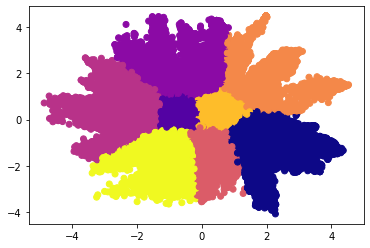

Plotting took 6.704824447631836 seconds
0.34350473
0.34354502
0.3425333
0.34285265
0.34208012
0.34370592
0.341579
0.3394968
0.34048253
0.3472316
0.3397522
0.33818454
0.343323
0.34226432
0.3340414
0.3350603
0.33533013
0.33909532
0.33823258
0.34095204
0.34269208
0.34613082
0.3371068
0.34034187
0.33998263
0.34177256
0.34464496
0.34706992
0.34641603
0.34345272
0.34399283
0.33793214
0.3459383
0.34679824
0.34328353
0.3424852
0.33706304
0.34229097
0.34424537
0.33575937
0.34455743
0.34059554
0.3318938
0.3431578
0.34523925
0.33795053
0.3367314
0.34402725
0.33495536
0.33817038
0.33887306
0.3457155
0.34001565
0.34324503
0.34074503
0.34023306
0.34285882
0.3409681
0.33625746
0.33678436
0.34157264
0.34137526
0.34246212
0.34229863
0.33693573
0.3437482
0.33799896
0.3389477
0.34506637
0.34048104
0.3409444
0.3364636
0.33554208
0.34092715
0.34190714
0.33713418
0.33864546
0.3429296
0.33547026
0.3391839
0.3400662
0.3401565
0.34032035
0.33679044
0.3400979
0.336116
0.34281215
0.34413093
0.33852318
0.3353746


In [12]:
run_pipeline_kmeans("ecfp.pkl")